# 2. Poisson process with unknown background: limits and p-values

In [1]:
from scipy import optimize
from scipy.special import gamma
import numpy as np
import matplotlib.pyplot as plt

## 0. Repeat from point estimation

In [2]:
# Poisson pdf
def poisson(n, mu):
    if type(n) == int:
        ans = pow(mu,n) * np.exp(-mu) / np.math.factorial(n)
    else:
        # if n is not integer (we will need it for Asimov), use the generalised expression
        if n < 0:
            ans = 0
        else:
            ans = n*np.log(mu)-mu-np.log(gamma(n+1.))
            ans = np.exp(ans)
    return ans
# likelihood
def lh(D, Q, s, b, k):
    # protection to stay within physical range
    if (D<=0 or Q<=0 or s+b<0 or b*k<0):
        return 0
    return poisson(D,s+b)*poisson(Q,b*k)

# -2 * log(likelihood)
def lnlh(D, Q, s, b, k):
    l = lh(D, Q, s, b, k)
    if (l<=0):
        return 1e99
    return -2*np.log(l)

# the following "wrappers" are need to call scipy.optimize.fmin
#   whichwhich minimises a function w.r.t. its first parameter
# likelihood as a function of b (s is a parameter)
def lh_b(x,*args):
    b = x[0]
    s = args[3]
    D = args[0]
    Q = args[1]
    k = args[2]
    return lh(D,Q,s,b,k)

# -2 * log(likelihood) as a function of b (s is a parameter)
def lnlh_b(x,*args):
    b = x[0]
    s = args[3]
    D = args[0]
    Q = args[1]
    k = args[2]
    return lnlh(D,Q,s,b,k)

In [3]:
# definitions
D = 13
B = 2.6
dB = 0.7
# derived quantities
Q = int((B/dB)**2)
k = B/(dB**2)

# global minimum
bhat = B
shat = D-B
lhmax = lh(D,Q,shat,bhat,k)
lnlhmin = lnlh(D,Q,shat,bhat,k)

# keep bhathat(s) for reference
s = 1
bhathat = optimize.fmin(lnlh_b,bhat,args=(D,Q,k,s),disp=False)

## 1. p-value against background-only hypothesis

In [4]:
ntoys = 10000

# here we adapt D and s0, so that we don't have to throw too many toys
D = 8
stoys = 4.3

# the value of the parameter s in the test statistic evaluation
stest = 0

def dist_teststat(s, st, ntoys):
    """
    Sample the test statistic distribution q(s), throwing toys from the value provided st.
    """
    ans = []
    for itoy in range(ntoys):
        # for each toy, we need to generate values of Q, B, and D
        # we call them Qt, Bt, Dt (t for toy)
        Qt = np.random.poisson(B*k)
        Bt = Qt/k
        Dt = np.random.poisson(st+Bt)

        # we use them to get the MLE for s: shat_t
        shat_t = Dt-Bt

        # denominator of q
        lht_den = lh(Dt,Qt,shat_t,Bt,k)

        # numerator of q
        bhathat_t = optimize.fmin(lnlh_b,Bt,args=(Dt,Qt,k,s),disp=False)
        bhathat_t = bhathat_t[0]
        lht_num = lh(Dt,Qt,s,bhathat_t,k)

        # compute q itself
        q = -2*np.log(lht_num/lht_den) if lht_den>0 else 0

        # set q to 0 when the MLE for s is negative
        if (shat_t<0):
            q = 0

        # store the test statistic value
        ans.append(q)
    return ans

In [5]:
# s+b
teststat_sb = dist_teststat(stest, stoys, ntoys)

# b only
teststat_b = dist_teststat(stest, 0, ntoys)

# value in data
bhathat_data = optimize.fmin(lnlh_b,B,args=(D,Q,k,stest),disp=False)
bhathat_data = bhathat_data[0]
bhat = B
shat = D-B
lhmax = lh(D,Q,shat,bhat,k)
qdata = -2*np.log(lh(D,Q,stest,bhathat_data,k)/lhmax)
print('Test statistic value in data:', qdata)

Test statistic value in data: 5.996464227774317


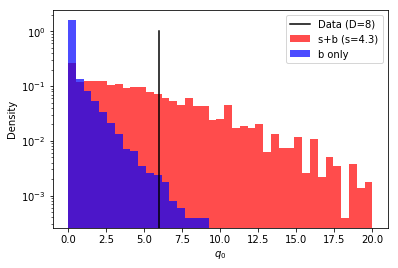

In [6]:
# draw the distribution
bins = np.linspace(0, 20, 40)
fig, ax = plt.subplots()
ax.hist(teststat_sb, bins, label='s+b (s={})'.format(stoys), density=True, color='red', alpha=0.7)
ax.hist(teststat_b, bins, label='b only', density=True, color='blue', alpha=0.7)
# draw a line where the data value is
xl = [qdata, qdata]
yl = [0, 1]
ax.plot(xl, yl, label='Data (D={})'.format(D), color='black')
ax.set_xlabel('$q_0$')
ax.set_ylabel('Density')
ax.set_yscale('log')
ax.legend()
plt.show()

In [7]:
# define some functions which will be useful for playing with p-values

from scipy.special import erfinv

def pval(dist, val):
    """
    Returns the p-value corresponding to the value val of the test statistic,
    given it distribution dist provided as an array
    """
    return len([x for x in dist if x > val]) / len(dist)

def norm_Phi_inv(x):
    """
    relating the inverse of the Phi, the cdf of the normal distribution,
    with that of the error function
    """
    return np.sqrt(2) * erfinv(2*x - 1)

def zval_1sided(pval):
    """
    Returns the 1-sided z-value (number of Gaussian sigmas) 
    corresponding to the p-value provided
    """
    return norm_Phi_inv(1-pval/2)

In [8]:
# observed p-value and corresponding z-value
pval_obs = pval(teststat_b,qdata)
zval_obs = zval_1sided(pval_obs)
print ("observed p-value:", pval_obs)
print ("observed z-value:", zval_obs)

observed p-value: 0.0029
observed z-value: 2.978143684422971


In [9]:
# median expected p-value
qexp = np.median(teststat_sb)
pval_exp = pval(teststat_b,qexp)
zval_exp = zval_1sided(pval_exp)
print ("for s = ", stoys, ":")
print ("median expected test stat:", qexp)
print ("expected p-value:", pval_exp)
print ("expected z-value:", zval_exp)

for s =  4.3 :
median expected test stat: 3.8223198899130106
expected p-value: 0.0123
expected z-value: 2.5034185153291393


In [10]:
# bonus: Asimov
# assume we observed exactly the expectation
D_Asimov = stoys+B
Q_Asimov = B*k
B_Asimov = B
bhathat_Asimov = optimize.fmin(lnlh_b,B,args=(D_Asimov,Q_Asimov,k,stest),disp=False)
bhathat_Asimov = bhathat_Asimov[0]
shat_Asimov = D_Asimov-B_Asimov
qAsimov = -2*np.log(lh(D_Asimov,Q_Asimov,stest,bhathat_Asimov,k)/lhmax)
if (shat_Asimov<0):
    qAsimov = 0
pval_Asimov = pval(teststat_b,qAsimov)
zval_Asimov = zval_1sided(pval_Asimov)
print ("Asimov expected test stat:", qAsimov)
print ("expected p-value:", pval_Asimov)
print ("expected z-value:", zval_Asimov)

Asimov expected test stat: 3.6958615238317414
expected p-value: 0.0135
expected z-value: 2.470299428362589


**Comment:** the "Asimov" dataset indeed gives roughly the same answer as the median from the distribution of the test-statistic in the s+b hypothesis. Small differences are expected since we are not dealing with that large a number of events: the Asimov dataset relies on the asymptotic aproximation.

In [11]:
# s/sqrt(b)
bhat = B
shat = D-B
print ("\nfor observed values, shat = ", shat, " and bhat = ", bhat, ":")
print ("s/sqrt(b) = ", shat/np.sqrt(bhat))


for observed values, shat =  5.4  and bhat =  2.6 :
s/sqrt(b) =  3.348937833908628


**Comment:** This is not far from what we got for the observed p-value, but a bit larger. This is because this simple formula, $s / \sqrt{b}$, is only valid for large numbers of events. It tends to over-estimate the p-value ("significance") for small numbers of events.

## 2. Hypothesis test inversion

In [12]:
# compute the observed CLsb for several values of s
ntoys=1000
array_s = np.arange(5,17,1)
array_CLsb_obs = []

# back to the published numbers
D = 13
s0 = 7.3
bhat = B
shat = D-B
lhmax = lh(D,Q,shat,bhat,k)
lnlhmin = lnlh(D,Q,shat,bhat,k)

for stest in array_s:
    # get the expected distribution for the test statistic (expected for s=stest)
    teststat_sb = dist_teststat(stest, stest, ntoys)
    
    # value in data
    bhathat_data = optimize.fmin(lnlh_b,B,args=(D,Q,k,stest),disp=False)
    bhathat_data[0]
    qdata = -2*np.log(lh(D,Q,stest,bhathat_data,k)/lhmax)
    CLsb_obs = pval(teststat_sb,qdata)
    
    array_CLsb_obs.append(CLsb_obs)

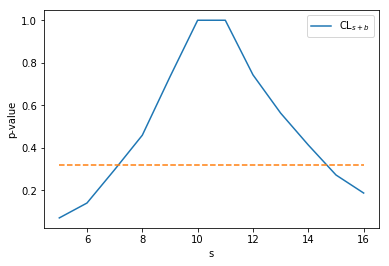

In [13]:
# draw results
# 68% CL
alpha = 1-0.68

fig, ax = plt.subplots()
ax.plot(array_s, array_CLsb_obs, label='CL$_{s+b}$')
ax.plot([array_s[0], array_s[-1]], [alpha, alpha], linestyle='--')
ax.set_xlabel('s')
ax.set_ylabel('p-value')
ax.legend()
plt.show()

The interval can be read as the region where the p-value for the signal+background hypothesis, using $q(s)$ as a test statistic (blue line), is above alpha (1 - CL, orange line).

In [14]:
# 68% CL interval from hypothesis testing inversion
# let's find the s values for which the p-value is equal to alpha

alpha = 1-0.68

# do the interpolation between the few s points that we have,
# in order to obtain a continuous function
from scipy import interpolate
CLsb = interpolate.interp1d(array_s, array_CLsb_obs)

# we can define a function |p-value(s) - alpha| and find its roots (or minimize it)
def dCLsb(s,alpha):
    return abs(CLsb(s)-alpha)

# there are two roots (two minima) to this dCLsb function, which we find by starting
# from below the first one (e.g. 6) or above the second one (e.g. 14)
s_low = optimize.fmin(dCLsb,6,args=(alpha,),disp=False)
s_high = optimize.fmin(dCLsb,14,args=(alpha,),disp=False)
print("The {}% CL interval is [{}, {}]".format(100*(1-alpha), s_low[0], s_high[0]))

The 68.0% CL interval is [7.141992187500003, 14.65958251953125]


In [15]:
# for comparison: profile likelihood interval
# the contents of this cell is taken from the answers to the exercise on point and interval estimation.

# arrays for plotting
s_vals = []
proflh_vals = []

# global minimum
bhat = B
shat = D-B
lhmax = lh(D,Q,shat,bhat,k)
lnlhmin = lnlh(D,Q,shat,bhat,k)

# fill the arrays
ds = 0.1
for i_s in range(1,200):
    s = i_s * ds
    bhathat = optimize.fmin(lnlh_b,bhat,args=(D,Q,k,s),disp=False)
    bhathat = bhathat[0]
    s_vals.append(s)
    proflh_vals.append(lnlh(D,Q,s,bhathat,k)-lnlhmin)

# build a continuous profile likelihood function by interpolating between the values we have computed
proflh = interpolate.interp1d(s_vals, proflh_vals)

def dproflh(s):
    return abs(proflh(s)-1)

s_low_proflh = optimize.fmin(dproflh,s_low,disp=False)
s_low_proflh = s_low_proflh[0]
s_high_proflh = optimize.fmin(dproflh,s_high,disp=False)
s_high_proflh = s_high_proflh[0]

print ("68% C.L. (2 Delta ln L = 1) profile likelihood interval: [{}, {}]".format(s_low_proflh,s_high_proflh))

68% C.L. (2 Delta ln L = 1) profile likelihood interval: [7.119411914348605, 14.64866657063365]


Comment: as expected, they are basically the same! They both correspond to the Feldman-Cousins interval (with likelihood ratio ordering), except that the hypothesis test inversion required us to sample the test statistic distribution and only test few values of s, and hence is less precise.

# 3. Figures of merit
## Where does $s/\sqrt{b}$ come from, and what does it mean?
In the limit where $s$ and $b$ are large, the data $D$ approximately follow a Gaussian law with mean $s+b$ and standard deviation $\sqrt{s+b}$. The p-value under the background-only hypothesis ($s=0$) is then the probability to find $D$ greater or equal than the value observed:
$$p_0 = 1- \Phi\left( \frac{D-b}{\sqrt{b}} \right)$$
The corresponding significance is $Z_0 = \Phi^{-1}(1-p_0) = (D-b) / \sqrt{b}$. For given observed values $D$ and $B$, injecting $\hat{b} = B$ and $\hat{s} = D-B$, one then gets
$$Z_0 = \hat{s} / \sqrt{\hat{b}}$$

**$s/\sqrt{b}$ corresponds asymptotically to the p-value under the background-only hypothesis, when $b$ is large. It is the figure of merit to be optimised for observation.**

## Where does $s/\sqrt{s+b}$ come from, and what does it mean?
Sometimes another "figure of merit" (simple formula) is used: $s/\sqrt{s+b}$. When should it be used?

Let's start now from signal+background hypothesis. We measure again $D$ events, and assume large $s$ and $b$, such that $D$ follows a Gaussian with mean $s+b$ and standard deviation $\sqrt{s+b}$. In addition, we now assume $b$ to be perfectly known. The MLE for $s$ is $\hat{s} = D-b$, and its variance is $V(\hat{s}) = V(D) = s+b$.  The "relative precision" of the measurement is then:
$$\frac{\sigma(\hat{s})}{\hat{s}} = \frac{\sqrt{\hat{s}+b}}{\hat{s}}$$

**$s/\sqrt{s+b}$ is the inverse of the relative precision of $\hat{s}$ ("how many Gaussian sigmas $\hat{s}$ is away from 0"). It is the figure of merit to be optimised for the precision of a measurement, or for upper limits.**